# Analysis of supervised machine learning algorithms 

In this notebook I will attempt to analyse the performance of various machine learning algoriths and their predictive power on the S&P 500.

In [4]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


/anaconda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [5]:
from datetime import datetime
import Methods as models
import Predictors as predictors
import stock_tools as st
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import gridspec
from IPython.display import Image, display

Create a template with the available variables

In [3]:
interest = 'SPY'
start_date = datetime.strptime('2000-01-01', '%Y-%m-%d')
end_date = datetime.strptime('2010-12-31', '%Y-%m-%d')

In [4]:
# Get the data and correct for fluctuations
data = st.get_data(start_date,end_date,from_file=True)
corr_data = st.ohlc_adj(data)
# Create a predictors class which we will base our decisions from
pred = predictors.Predictors(corr_data)

The data is far too noisy to make accurate predictions. We apply a 5 day exponential rolling filter. This should preserve shape and reduce noise.

In [5]:
pred.e_filter(5)

In [6]:
def make_logic(x=0.):
    """
    Makes this signal if the Closing price has gone above a percentage
    
    :param x: Number describing the percentage change.
    :return: Pandas DataFrame containing the true/false of the percentage change.
    """
    return ((1 - pred.data.Close.shift(1).div(pred.data.Close)) > x)*1

## Methodology

As a start, we test all algorithms for applicability. Make an indicator for raise or fall. From one day to the next. In these cases the model is created on 0.8 of the previous years data and then tested on 20% of the data. A walk forward optimization is performed, using new train and test data. In the case of XGboost, walk forward optimization has not been performed as it is too computationally expensive.

The technical indicators which have been selected are:

'meanfractal'

'RStok0'

'mom'

'MACD_l'

These were chosen from running all indicators through xgboost and selecting those which contribute the most. See the file xgboost_test for the methodology.

### Predicting the day thats been

Using the technical indicators given above, the following machine learning algorithms have been used. KNN, Linear regression, Gaussian Naive Bayes, Random forest and gradient boosting decision trees.

In [ ]:
# First try a knn model.
m = []
m.append(models.ML(pred.props))
m[-1].pred.PHH = make_logic()
ret = m[-1].knn_learn(6, 252, {'meanfractal', 'RStok0', 'mom', 'MACD_l'}, "PHH")
knn = ret.ACC.mean()
# KNN model accuracy: 0.82500665779

# Now try a linear classifier model
m.append(models.ML(pred.props))
m[-1].pred.PHH = make_logic()
ret = m[-1].linear_learn(1, 252, {'meanfractal', 'RStok0', 'mom', 'MACD_l'}, "PHH")
ll = ret.ACC.mean()
# Linear model accuracy: 0.910972037284

# Try a Gaussian interpretation of the Naive Byers
m.append(models.ML(pred.props))
m[-1].pred.PHH = make_logic()
ret = m[-1].GaussianNB(252, {'meanfractal', 'RStok0', 'mom', 'MACD_l'}, "PHH")
gnb = ret.ACC.mean()
# GaussianNB model accuracy: 0.89650244119

# Try a random forrest
m.append(models.ML(pred.props))
m[-1].pred.PHH = make_logic()
ret = m[-1].randomForset_learn(3, 252, {'meanfractal', 'RStok0', 'mom', 'MACD_l'}, "PHH")
rf = ret.ACC.mean()
# RandomForest model accuracy: 0.932871726587

# Try an xgboosted random forrest
m.append(models.ML(pred.props))
temp = make_logic()
sd = temp.index[252]
ret = m[-1].short_xgboost_model(sd,252*2,temp)
XB = ret.ACC.mean()
# Xgboost model accuracy: 0.9505

# The computation time for the SCV model is too great for my computer.
do_svc = False
if do_svc:
    kernels = {'linear', 'poly', 'rbf', 'sigmoid'}
    for kernel in kernels:
        m.append(models.ML(pred.props))
        m[-1].pred.PHH = ((1 - pred.data.Close.shift(1).div(pred.data.Close)) > 0) * 1
        ret = m[-1].SVC_learn(252, c=1, p={'meanfractal', 'Stok0', 'mom', 'MACD_l'}, y_colums = "PHH",kernel=kernel)

So with all of these models, it looks like it's a Random Forest model or an xboost model.

### Predicting the future - 1 day

In [ ]:
# Now lets try looking forward 1 day.
m.append(models.ML(pred.props))
m[-1].pred.PHH = make_logic()
ret = m[-1].knn_learn(6, 252, {'meanfractal', 'RStok0', 'mom', 'MACD_l'}, "PHH",forward_look=1)
knnL = ret.ACC.mean()
# KNN model accuracy: 0.666731793961

# Now try a linear classifier model
m.append(models.ML(pred.props))
m[-1].pred.PHH = make_logic()
ret = m[-1].linear_learn(1, 252, {'meanfractal', 'RStok0', 'mom', 'MACD_l'}, "PHH",forward_look=1)
llL = ret.ACC.mean()
# Linear model accuracy: 0.728925399645

# Try a Gaussian interpretation of the Naive Byers
m.append(models.ML(pred.props))
m[-1].pred.PHH = make_logic()
ret = m[-1].GaussianNB(252, {'meanfractal', 'RStok0', 'mom', 'MACD_l'}, "PHH",forward_look=1)
gnbL = ret.ACC.mean()
# GaussianNB model accuracy: 0.717744227353

# Try a random forrest
m.append(models.ML(pred.props))
m[-1].pred.PHH = make_logic()
ret = m[-1].randomForset_learn(3, 252, {'meanfractal', 'RStok0', 'mom', 'MACD_l'}, "PHH",forward_look=1)
rfL = ret.ACC.mean()
# RandomForest model accuracy: 0.655959147425

# Try an xgboosted random forrest
m.append(models.ML(pred.props))
temp = make_logic()
sd = temp.index[252]
ret = m[-1].short_xgboost_model(sd,252*1,temp,forward_look=1)
XBL = ret.ACC.mean()
# Predicted model accuracy: 0.699

### Predicting the future - 2 Days

In [ ]:
m.append(models.ML(pred.props))
m[-1].pred.PHH = make_logic()
ret = m[-1].knn_learn(6, 252, {'meanfractal', 'RStok0', 'mom', 'MACD_l'}, "PHH",forward_look=2)
knnL2 = ret.ACC.mean()
# KNN model accuracy: 0.570910706353

# Now try a linear classifier model
m.append(models.ML(pred.props))
m[-1].pred.PHH = make_logic()
ret = m[-1].linear_learn(1, 252, {'meanfractal', 'RStok0', 'mom', 'MACD_l'}, "PHH",forward_look=2)
llL2 = ret.ACC.mean()
# Linear model accuracy: 0.625890715238

# Try a Gaussian interpretation of the Naive Byers
m.append(models.ML(pred.props))
m[-1].pred.PHH = make_logic()
ret = m[-1].GaussianNB(252, {'meanfractal', 'RStok0', 'mom', 'MACD_l'}, "PHH",forward_look=2)
gnbL2 = ret.ACC.mean()
# GaussianNB model accuracy: 0.628342958685

# Try a random forrest
m.append(models.ML(pred.props))
m[-1].pred.PHH = make_logic()
ret = m[-1].randomForset_learn(3, 252, {'meanfractal', 'RStok0', 'mom', 'MACD_l'}, "PHH",forward_look=2)
rfL2 = ret.ACC.mean()
# RandomForest model accuracy: 0.558960462017

# Try an xgboosted random forrest
m.append(models.ML(pred.props))
temp = make_logic()
sd = temp.index[252]
ret = m[-1].short_xgboost_model(sd,252*1,temp,forward_look=2)
XBL2 = ret.ACC.mean()
# Xgboost model accuracy: 0.58

# Lets visualise this
ModelsAccuracy = pd.DataFrame({"0 Day": [knn, ll, gnb, rf, XBL],
                               "1 Day": [knnL, llL, gnbL, rfL, XBL],
                               "2 Days": [knnL2, llL2, gnbL2, rfL2, XBL2]})
ax = ModelsAccuracy.plot.bar()
ax.set_xticklabels(["KNN", "Lin", "GNB", "RF", "XGB"])
ax.set_ylabel("Accuracy")
plt.show()

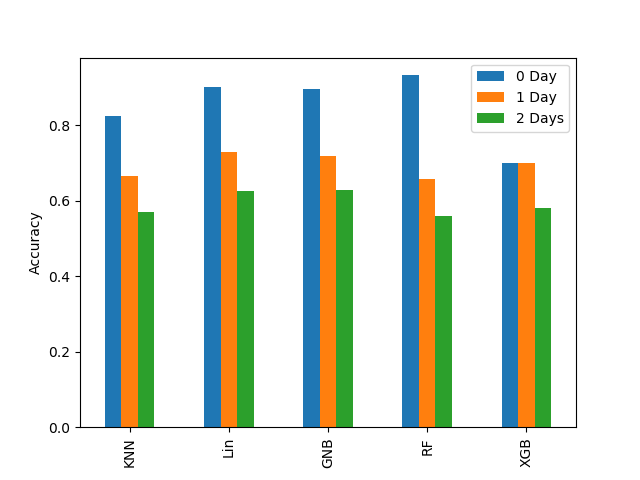

In [6]:
display(Image(filename="Images/AccVDay.png"))

Now, because of commission (C) just saying profit or loss is not enough. We need to say if tomorrow we can get above the break even point. This occurs when the percentage increase is greater than 1+C/1-C -1. So now lets test  the models against this criteria.

In [ ]:
mm = []
be = {"knn": [], "ll": [], "gnb": [], "rf": [],"XB": []}
for i in range(0, 3):
    mm.append(models.ML(pred.props))
    mm[-1].pred.PHH = make_logic(0.0051)
    ret = mm[-1].knn_learn(6, 252, {'meanfractal', 'RStok0', 'mom', 'MACD_l'}, "PHH",forward_look=i)
    be['knn'].append(ret.ACC.mean())

    mm.append(models.ML(pred.props))
    mm[-1].pred.PHH = make_logic(0.0051)
    ret = mm[-1].linear_learn(1, 252, {'meanfractal', 'RStok0', 'mom', 'MACD_l'}, "PHH",forward_look=i)
    be['ll'].append(ret.ACC.mean())

    mm.append(models.ML(pred.props))
    mm[-1].pred.PHH = make_logic(0.0051)
    ret = mm[-1].GaussianNB(252, {'meanfractal', 'RStok0', 'mom', 'MACD_l'}, "PHH",forward_look=i)
    be['gnb'].append(ret.ACC.mean())

    mm.append(models.ML(pred.props))
    mm[-1].pred.PHH = make_logic(0.0051)
    ret = mm[-1].randomForset_learn(3, 252, {'meanfractal', 'RStok0', 'mom', 'MACD_l'}, "PHH",forward_look=i)
    be['rf'].append(ret.ACC.mean())

    mm.append(models.ML(pred.props))
    temp = make_logic()
    sd = temp.index[252]
    ret = mm[-1].short_xgboost_model(sd,252*1,temp,forward_look=i)
    be['XB'].append(ret.ACC.mean())

# Now plot the accuracy. Well, this is surprising!
ModelsAccuracyP = pd.DataFrame(be)
ModelsAccuracyP = ModelsAccuracyP.transpose()
ModelsAccuracyP.columns = ["0 Day", '1 Day', '2 Day']
ax = ModelsAccuracyP.plot.bar()
ax.set_xticklabels(["KNN", "Lin", "GNB", "RF", "XGB"])
ax.set_ylabel("Accuracy")
plt.show()

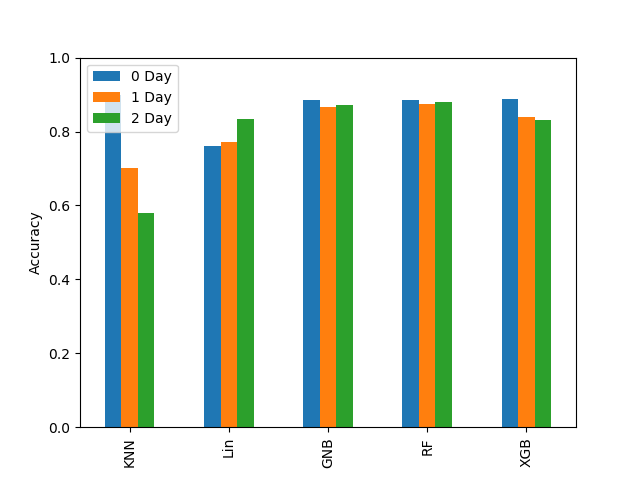

In [7]:
display(Image(filename="Images/AccVDayF.png"))

OK, so Random Forrest seems to be the best. Now lets see if it can model the percentage change. We perform models for a -1.5% to 2% change as this accounts for most of the daily fluctuations.

In [ ]:
fluc_m = []
fluc = np.arange(-.015, 0.02, 0.001)
ret = []
acc = []
for x in np.nditer(fluc):
    fluc_m.append(models.ML(pred.props))
    fluc_m[-1].pred.PHH = make_logic(x)
    # ret.append(fluc_m[-1].GaussianNB(252, {'meanfractal', 'RStok0', 'mom', 'MACD_l'}, "PHH",forward_look=1))
    ret.append(fluc_m[-1].randomForset_learn(3,252, {'meanfractal', 'RStok0', 'mom', 'MACD_l'}, "PHH",forward_look=1))
    acc.append(ret[-1].ACC.mean())

In [ ]:
actual = (1 - pred.data.Close.shift(1).div(pred.data.Close))
# Let's test this signal
i = 10 # A random date to inspect.
signal = [ret[j].PRED[i] for j in range(0,len(ret))]
plt.plot(fluc,signal,label='Signal')
plt.axvline(actual[i-1],color='r',label='Real')
ax = plt.gca()
ax.set_ylabel("Random Forest Prediction")
ax.set_xlabel('Price Change')
plt.show()

Now we have an array of back projected results for different price fluctuations. Lets find out the most probable. This should be fitted with a Heaviside function. But since we're backtesting over 3000 points, we'll let it slide and use the poor mans version. Note, this means that if one computed point is wrong we could get a drop when we don't mean to. Similarly, if it's all equal to (0, 1) we have an erroneous value.

In [ ]:
# This is what we are predicting.
change = pd.DataFrame({
    "Actual": actual,
    "Pred"  : 0})

for i in range(1,len(ret)):
    change["Pred"] = change["Pred"] + ((ret[i-1].PRED > ret[i].PRED)*fluc[i])

In [ ]:
change.to_csv('ml_predictions_all.csv', sep=',')
change = pd.read_csv('ml_predictions_all.csv' ,index_col=0, parse_dates=True)

In [ ]:
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
ax1 = plt.subplot(gs[0])
corr_data.Close.plot(label="SPY")
ax2 = plt.subplot(gs[1],sharex=ax1)
change["Actual"].plot(label="SPY Change")
change["Pred"].plot(label="Predicted Change")
ax1.set_ylabel("Share Price [$]")
ax2.set_xlabel("Time")
ax2.set_ylabel("Percenage Change")
plt.title("RandomForestClassifier")
plt.show()

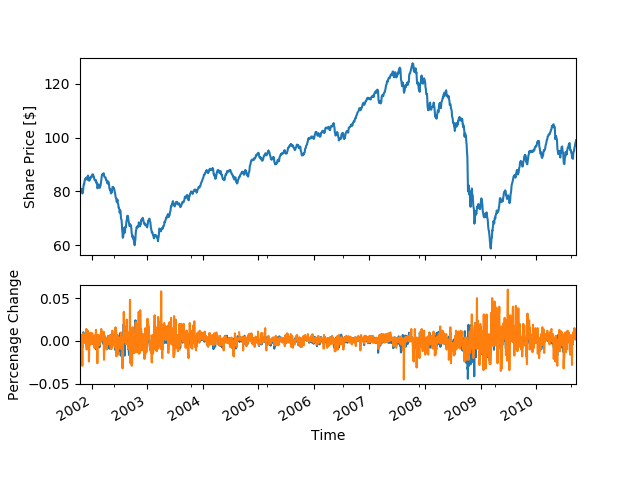

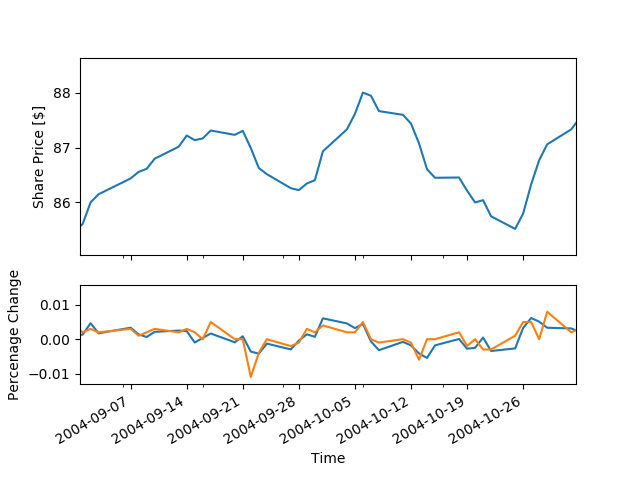

In [11]:
display(Image(filename="Images/Full_prediction.png"))
display(Image(filename="Images/Cropped_prediction.png"))